In [ ]:
n1 = np.random.normal((0, 100), 1, (500, 2))
n2 = np.random.normal((100, 0), 1, (500, 2))
n3 = np.random.normal((-100, 0), 1, (500, 2))
n4 = np.random.normal((0, -100), 1, (500, 2))

samples = 0.25*n1 + 0.25*n2 + 0.25*n3 + 0.25*n4

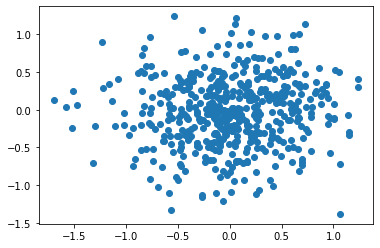

In [ ]:
plt.scatter(samples[:, 0], samples[:, 1])

# CMPE 462 - Project Phase 1

Muhammed Furkan Atasoy, 2017400216

Zehranaz Canfes, 2017205138

In [ ]:
import os
from PIL import Image
from natsort import natsorted
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [ ]:
!unzip phase1_files.zip -d phase1_files

In [ ]:
root_path = "/content/phase1_files/phase1_files/"

train_path = root_path + "3dshapes_train/"
test_path = root_path  + "3dshapes_test/"

train_img_paths = [train_path+x for x in natsorted(os.listdir(train_path))]
test_img_paths = [test_path+x for x in natsorted(os.listdir(test_path))]

train_imgs = np.array([np.array(Image.open(img_path).convert('L')).reshape(-1) / 255. for img_path in train_img_paths])
test_imgs = np.array([np.array(Image.open(img_path).convert('L')).reshape(-1) / 255. for img_path in test_img_paths])

train_orient = np.load(root_path + "orientations_train.npy")
test_orient = np.load(root_path + "orientations_test.npy")

In [ ]:
train_imgs.shape, test_imgs.shape, train_orient.shape, test_orient.shape

((10000, 4096), (1000, 4096), (10000,), (1000,))

In [ ]:
feature_count = 512
class_count = 15

### Dimensionality Reduction Method: PCA 

PCA is an unsupervised method to reduce the number of features in a dataset. In the case of images, PCA can be used to compress the vector consisting of pixel values. Because it finds the directions in which data varies most, PCA is a good methodology to compress features of data. Therefore, with a smaller feature vector, our linear regression starts to work efficiently and the computational cost is reduced. 

The final number of features is chosen to be 512. 

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(train, test, n_components):
  pca = PCA(n_components=n_components)
  train_reduced = pca.fit_transform(train)
  test_reduced = pca.transform(test)

  return train_reduced, test_reduced

In [ ]:
train_imgs_reduced, test_imgs_reduced = apply_pca(train_imgs, test_imgs, feature_count)

# Assignment 2

## 1.a)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
train_imgs_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(train_imgs)
train_imgs_tsne.shape

(10000, 2)

In [ ]:
def preprocess_labels(labels):
  # convert to class numbers from 0 to 14
  step_size = 4.28571429 # step size between orientations
  labels = np.round((labels+30) / step_size).astype(int)

  return labels

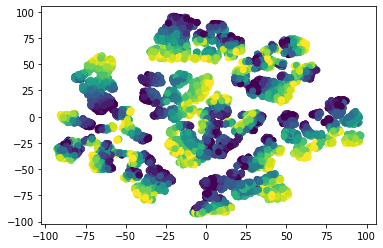

In [ ]:
plt.scatter(train_imgs_tsne[:, 0], train_imgs_tsne[:, 1], c=preprocess_labels(train_orient))

It doesn't look like linearly seperable. Because the elements of the same class are apart from each other and there are the elements of other classes that doesn't allow to find a linear decision boundry that can seperate the classes. Therefore, we can easily say that we need to use non-linear classifier to get high accuracy on classification. Because logistic regression is a non-linear method, we can use it for this dataset.

## 1.b)

### Derivation of the gradient of the loss function - $ \nabla_w{E_{in}}$

Our loss function (cross-entropy) is applied to logits $o_i(x)$ which are the outputs of the softmax function. Thus, to calculate the gradient of our loss $\mathcal L(o_i)$ with softmax, we need to find the following:

$$\frac{\partial \mathcal L}{\partial w} =  \frac{\partial{\mathcal L}}{\partial z}\cdot \frac{\partial z}{\partial w}$$ 

and 

$$\frac{\partial L}{\partial z} = \frac{\partial L}{\partial o_i}\cdot \frac{\partial o_i}{\partial z} $$ 

where $z = w^T x+ b$ as accepted in the lectures. 

Now, we shall first start with the gradient of the softmax function. 

#### a. Gradient of Softmax

The softmax is defined by

$$ o_i = \frac{e^{z_i}}{\sum_k e^{z_k}}$$ 

The derivative of softmax $\frac{\partial o_i}{\partial z_j}$ is found by using the quotient rule. We should consider 2 cases: 

**Case 1:** $i=j$
$$ \frac{\partial e^{z_i}}{\partial z_j} = e^{z_j}$$

$$ \frac{\sum_k e^{z_k}}{z_j} = e^{z_j}  $$
$$ \frac{\partial o_i}{\partial z_j}  = \frac{\partial \frac{e^{z_i}}{\sum_k e^{z_k}}}{\partial z_j} = \frac{e^{z_j}\cdot \sum_k e^{z_k} - e^{z_i}\cdot e^{z_j}}{(\sum_k e^{z_k})^2} \\ = \frac{e^{z_j} (\sum_k e^{z_k} -e^{z_i})}{(\sum_k e^{z_k})^2} = \frac{e^{z_j}}{\sum_k e^{z_k}}\cdot \frac{\sum_k e^{z_k} -e^{z_i}}{\sum_k e^{z_k}} \\ \implies \frac{\partial o_i}{\partial z_j} = o_i\cdot (1-o_i).$$ 

**Case 2:** $i\neq j$ 
$$ \frac{\sum_k e^{z_k}}{z_j} = e^{z_j}  $$
$$ \frac{\partial e^{z_i}}{\partial z_j} = 0 $$

$$ \frac{\partial o_i}{\partial z_j}  = \frac{\partial \frac{e^{z_i}}{\sum_k e^{z_k}}}{\partial z_j}  = \frac{0 - e^{z_i}e^{z_j}}{(\sum_k e^{z_k})^2}\\ = \frac{-e^{z_i}}{\sum_k e^{z_k}} \cdot \frac{e^{z_j}}{\sum_k e^{z_k}}$$

$$ \implies \frac{\partial o_i}{\partial z_j} = -o_i\cdot o_j $$

#### b. Gradient of Cross Entropy Loss

Cross entropy is defined by: 

$$ \mathcal L = -\sum_i y_i\cdot \log(o_i) $$

Since we have seen above that the gradient of the softmax depends on the value $i$, then we should seperate the derivative of the cross entropy into two parts as follows: 

$$ \frac{\partial \mathcal L}{\partial z_j} = \frac{\partial \mathcal L}{\partial o_i}\cdot \frac{\partial o_i}{\partial z_i} + \sum_{j\neq i} \frac{\partial \mathcal L}{\partial o_i}\cdot \frac{\partial o_i}{z_j}$$ 

where 

$$ \frac{\partial \mathcal L}{\partial o_i} = -\frac {y_i} {o_i}$$

Therefore, 

$$  \frac{\partial \mathcal L}{\partial z_j} =  -\frac {y_i} {o_i} \cdot (o_i (1- o_i)) + \sum_{i\neq j} -\frac {y_i} {o_i}\cdot (-o_i\ o_j) $$

$$ \frac{\partial \mathcal L}{\partial z_j} = -y_j + y_j o_j+ \sum_{i\neq j} y_io_j = -y_i+\sum_i y_i o_j = -y_j + o_j \sum_i y_i$$

We know that $y$ is a one hot encoded vector for the labels. Therefore,  
$$ \sum_i y_i = 1$$

$$ \implies \frac{\partial \mathcal L}{\partial z_j} =o_j-y_j $$

#### c. Gradient of the overall loss according to $w$


$$\frac{\partial \mathcal L}{\partial w} =  \frac{\partial{\mathcal L}}{\partial z}\cdot \frac{\partial z}{\partial w}$$ 

$$ \frac{\partial z}{\partial w} = x $$

$$ \implies \frac{\partial \mathcal L}{\partial w} = (o-y)\cdot x $$


In [ ]:
def loss_function(n, logits, targets):
  loss = -(np.sum(targets * np.log(logits)))/n 
  return loss

In [ ]:
def soft_threshold(beta, lambd):
    if beta < - lambd:
        return beta + lambd
    elif beta > lambd:
        return beta - lambd
    else: 
        return 0

In [ ]:
def grad_function(X, n, targets, logits, regularization=False, lambd=1, weights=None):
    if regularization == "l2":
      grad = (-(np.dot(X.T,(targets - logits))) + lambd * np.sum(weights)) / n   
    if regularization == "l1":
      grad = (-(np.dot(X.T,(targets - logits))) + soft_threshold(np.sum(weights), lambd)) / n
    else:
      grad = -(np.dot(X.T,(targets - logits))) / n   

    return grad 

In [ ]:
def softmax(z):
    logits = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T 
    return logits

In [ ]:
def get_one_hot_encoding(labels):
  one_hot = np.eye(class_count)[labels]
  return one_hot

In [ ]:
def train(X, y, epoch_num, lr=1, regularization=False, lambd=1):
  weights = np.random.normal(size=(X.shape[1], y.shape[1])) / 10.

  for i in range(epoch_num):
    z = X @ weights
    logits = softmax(z)

    error = loss_function(X.shape[0], logits, y)
    grad = grad_function(X, X.shape[0], y, logits, regularization, lambd, weights)
    weights = weights - lr*grad

    if i % 10 == 0:
      print("Epoch ", i, "Error: ", np.round(error, 3))
  
  return weights

In [ ]:
def predict(X, weights):
  z = X @ weights
  logits = softmax(z)
  preds = np.argmax(logits,axis=1)

  return preds

In [ ]:
def acc_metric(targets, preds):
  correct = np.sum(targets == preds)
  acc = correct / len(targets)

  return acc

## 1.c)

In [ ]:
def cross_validation_error(train_imgs, train_orient, k, epoch, params=[], tune="learning_rate", lr=None, lambd=None,  regularization=False):
  step = int(train_imgs.shape[0] / k)
  acc_dict = {}
    
  
  for param in params:
    print(f"{tune}: ", param)

    accs = []
    for i in range(k):
      print("Fold ",i)
      print("--------------------------")

      X_val = train_imgs[step*i: step*(i+1)]
      X_val = np.append(X_val, np.ones((X_val.shape[0], 1)), axis=1) # add bias

      X_train = np.concatenate((train_imgs[:step*i], train_imgs[step*(i+1):]), axis=0)
      X_train = np.append(X_train, np.ones((X_train.shape[0], 1)), axis=1) # add bias

      y_val = train_orient[step*i: step*(i+1)]
      y_val = preprocess_labels(y_val)

      y_train = np.concatenate((train_orient[:step*i], train_orient[step*(i+1):]), axis=0)
      y_train = preprocess_labels(y_train)

      if tune == "learning_rate":
        weights = train(X_train, get_one_hot_encoding(y_train), epoch, lr=param)
      if tune == "lambda":
        weights = train(X_train, get_one_hot_encoding(y_train), epoch, lr, regularization=regularization, lambd=param)

      preds = predict(X_val, weights)
      acc = acc_metric(y_val, preds)

      print("Accuracy:", acc)
      accs.append(acc)

    acc_dict[param] = np.mean(accs)
  
  return acc_dict

In [ ]:
epoch = 100
learning_rates = np.arange(0.1, 1.1, 0.1)
k = 5

acc_dict = cross_validation_error(train_imgs_reduced, train_orient, k, epoch, params=learning_rates, tune="learning_rate")

learning_rate:  0.1
Fold  0
--------------------------
Epoch  0 Error:  3.232
Epoch  10 Error:  2.493
Epoch  20 Error:  2.199
Epoch  30 Error:  1.98
Epoch  40 Error:  1.807
Epoch  50 Error:  1.664
Epoch  60 Error:  1.545
Epoch  70 Error:  1.443
Epoch  80 Error:  1.354
Epoch  90 Error:  1.276
Accuracy: 0.8545
Fold  1
--------------------------
Epoch  0 Error:  3.262
Epoch  10 Error:  2.372
Epoch  20 Error:  2.108
Epoch  30 Error:  1.909
Epoch  40 Error:  1.75
Epoch  50 Error:  1.618
Epoch  60 Error:  1.506
Epoch  70 Error:  1.41
Epoch  80 Error:  1.326
Epoch  90 Error:  1.252
Accuracy: 0.799
Fold  2
--------------------------
Epoch  0 Error:  3.135
Epoch  10 Error:  2.419
Epoch  20 Error:  2.146
Epoch  30 Error:  1.941
Epoch  40 Error:  1.777
Epoch  50 Error:  1.642
Epoch  60 Error:  1.527
Epoch  70 Error:  1.428
Epoch  80 Error:  1.342
Epoch  90 Error:  1.266
Accuracy: 0.82
Fold  3
--------------------------
Epoch  0 Error:  3.126
Epoch  10 Error:  2.435
Epoch  20 Error:  2.146
Epoch  

In [ ]:
acc_dict

{0.1: 0.8321,
 0.2: 0.9405000000000001,
 0.30000000000000004: 0.9661,
 0.4: 0.9818,
 0.5: 0.9870000000000001,
 0.6: 0.99,
 0.7000000000000001: 0.9940999999999999,
 0.8: 0.9692000000000001,
 0.9: 0.9456999999999999,
 1.0: 0.9384}

In [ ]:
lr = max(acc_dict, key=acc_dict.get)

## 1.d)

In [ ]:
# Train
X_train = np.append(train_imgs_reduced, np.ones((train_imgs_reduced.shape[0], 1)), axis=1) # add bias
y_train = preprocess_labels(train_orient)

X_test = np.append(test_imgs_reduced, np.ones((test_imgs_reduced.shape[0], 1)), axis=1) # add bias
y_test = preprocess_labels(test_orient)

weights = train(X_train, get_one_hot_encoding(y_train), epoch, lr)

preds = predict(X_train, weights)
acc_train = acc_metric(y_train, preds)

preds = predict(X_test, weights)
acc_test = acc_metric(y_test, preds)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

Epoch  0 Error:  3.336
Epoch  10 Error:  1.819
Epoch  20 Error:  0.965
Epoch  30 Error:  0.74
Epoch  40 Error:  0.606
Epoch  50 Error:  0.517
Epoch  60 Error:  0.453
Epoch  70 Error:  0.404
Epoch  80 Error:  0.366
Epoch  90 Error:  0.335
---------------------------
Train Accuracy: 0.9956 Test Accuracy: 0.995


`Train Accuracy: 0.9962 Test Accuracy: 0.996`

## 1.e)

Tune lambda for L2-regularization via cross validation

In [ ]:
epoch = 100
k = 5
lambdas = [0.1, 1, 2, 3, 4]

acc_dict = cross_validation_error(train_imgs_reduced, train_orient, k, epoch, params=lambdas, tune="lambda", lr=lr,  regularization="l1")

lambda:  0.1
Fold  0
--------------------------
Epoch  0 Error:  2.968
Epoch  10 Error:  1.696
Epoch  20 Error:  1.018
Epoch  30 Error:  0.748
Epoch  40 Error:  0.611
Epoch  50 Error:  0.521
Epoch  60 Error:  0.456
Epoch  70 Error:  0.407
Epoch  80 Error:  0.368
Epoch  90 Error:  0.337
Accuracy: 0.9935
Fold  1
--------------------------
Epoch  0 Error:  3.16
Epoch  10 Error:  1.854
Epoch  20 Error:  0.956
Epoch  30 Error:  0.738
Epoch  40 Error:  0.606
Epoch  50 Error:  0.517
Epoch  60 Error:  0.452
Epoch  70 Error:  0.403
Epoch  80 Error:  0.364
Epoch  90 Error:  0.333
Accuracy: 0.993
Fold  2
--------------------------
Epoch  0 Error:  3.284
Epoch  10 Error:  1.663
Epoch  20 Error:  1.03
Epoch  30 Error:  0.788
Epoch  40 Error:  0.607
Epoch  50 Error:  0.512
Epoch  60 Error:  0.447
Epoch  70 Error:  0.398
Epoch  80 Error:  0.36
Epoch  90 Error:  0.329
Accuracy: 0.993
Fold  3
--------------------------
Epoch  0 Error:  3.124
Epoch  10 Error:  1.592
Epoch  20 Error:  0.989
Epoch  30 Err

In [ ]:
acc_dict

{0.1: 0.9927999999999999,
 1: 0.9958,
 2: 0.9956000000000002,
 3: 0.9947000000000001,
 4: 0.9956000000000002}

In [ ]:
lambd = max(acc_dict, key=acc_dict.get)

## 1.f)

In [ ]:
# Feature Extraction
from skimage.filters import prewitt_h,prewitt_v

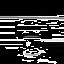

In [ ]:
# Visualize
index = 10

im = train_imgs[index].reshape(64, 64)
im = prewitt_h(im)

Image.fromarray(np.uint8(im * 255) , 'L')

In [ ]:
def extract_features(flat_imgs):
  imgs = flat_imgs.reshape(-1, 64, 64)
  horizontals = []
  verticals = []

  for img in imgs:
    horizontal = prewitt_h(img)
    vertical = prewitt_v(img)

    horizontals.append(horizontal.reshape(-1))
    verticals.append(vertical.reshape(-1))

  return np.array(flat_imgs), np.array(horizontals), np.array(verticals)

In [ ]:
# Extract additional features by applying horizontal and vertical edge detection filters and concatenate all of them to a single feature vector
flats_train, horizontals_train, verticals_train = extract_features(train_imgs)
flats_test, horizontals_test, verticals_test = extract_features(test_imgs)

flats_train, flats_test = apply_pca(flats_train, flats_test, feature_count)
horizontals_train, horizontals_test = apply_pca(horizontals_train, horizontals_test, feature_count)
verticals_train, verticals_test = apply_pca(verticals_train, verticals_test, feature_count)

train_features = np.concatenate((flats_train, horizontals_train, verticals_train), axis=1)
test_features = np.concatenate((flats_test, horizontals_test, verticals_test), axis=1)

In [ ]:
train_features.shape

(10000, 1536)

In [ ]:
train_features_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(train_features)

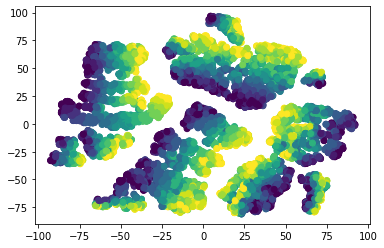

In [ ]:
# t-SNE with more discriminative features
plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=preprocess_labels(train_orient))

In [ ]:
# Train with more discriminative features
X_train = np.append(train_features, np.ones((train_features.shape[0], 1)), axis=1) # add bias
y_train = preprocess_labels(train_orient)

X_test = np.append(test_features, np.ones((test_features.shape[0], 1)), axis=1) # add bias
y_test = preprocess_labels(test_orient)

weights = train(X_train, get_one_hot_encoding(y_train), epoch, lr)

preds = predict(X_train, weights)
acc_train = acc_metric(y_train, preds)

preds = predict(X_test, weights)
acc_test = acc_metric(y_test, preds)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

Epoch  0 Error:  3.366
Epoch  10 Error:  0.82
Epoch  20 Error:  0.472
Epoch  30 Error:  0.348
Epoch  40 Error:  0.28
Epoch  50 Error:  0.236
Epoch  60 Error:  0.201
Epoch  70 Error:  0.175
Epoch  80 Error:  0.155
Epoch  90 Error:  0.14
---------------------------
Train Accuracy: 0.9998 Test Accuracy: 1.0


`Train Accuracy: 1.0 Test Accuracy: 1.0`

## 1.g)

In [ ]:
import seaborn as sns

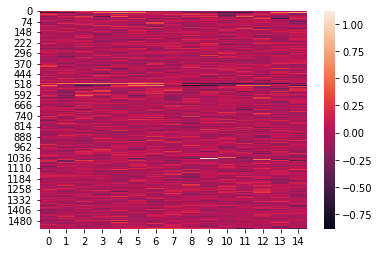

In [ ]:
# y axis is features 
# x axis is classes
sns.heatmap(weights)

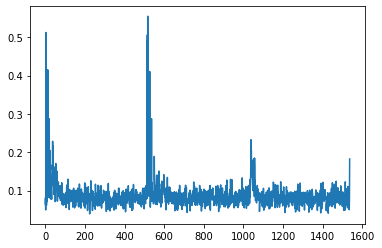

In [ ]:
# x axis is features 
weights_col = np.mean(np.abs(weights), axis=1)
plt.plot(weights_col)

After plotting the weight values with a heatmap and with a line plot. We can easily see that there are three part of the weights (0, 512, 1024) which are activated most (negatively or positively) so we can say that they are the features which affect the result most because they are the coefficients of the input features.

The most effective weights are gathered on 0, 512, 1024 because we extract three different feature vectors and concatenate them to a single feature vector and these three different feature vectors are obtained by applying PCA to flattened images and, as we talked above, PCA gives us the axises that have most variatition on the dataset in order.

The first image is original grayscale image, the second image is image obtained by applying horizontal edge detection filter, the third image is image obtained by applying vertical edge detection filter.

As you can see, the horizontal features are the one which are activated most. This makes sense because we are trying to predict the orientations of the images and the horizontal edges are the best way to detect orientations.

Extra note: the last column for the feature vector are bias.

## 1.h)

Tune lambda for l1-regularization (implementation is written above)

In [ ]:
epoch = 100
k = 5
lambdas = np.arange(0.1, 1.1, 0.1)

acc_dict = cross_validation_error(train_imgs_reduced, train_orient, k, epoch, params=lambdas, tune="lambda", lr=lr, regularization="l1")

lambda:  0.1
Fold  0
--------------------------
Epoch  0 Error:  3.201
Epoch  10 Error:  1.632
Epoch  20 Error:  0.972
Epoch  30 Error:  0.733
Epoch  40 Error:  0.602
Epoch  50 Error:  0.514
Epoch  60 Error:  0.45
Epoch  70 Error:  0.402
Epoch  80 Error:  0.364
Epoch  90 Error:  0.333
Accuracy: 0.9945
Fold  1
--------------------------
Epoch  0 Error:  3.269
Epoch  10 Error:  1.394
Epoch  20 Error:  0.951
Epoch  30 Error:  0.734
Epoch  40 Error:  0.602
Epoch  50 Error:  0.513
Epoch  60 Error:  0.449
Epoch  70 Error:  0.4
Epoch  80 Error:  0.362
Epoch  90 Error:  0.33
Accuracy: 0.993
Fold  2
--------------------------
Epoch  0 Error:  3.267
Epoch  10 Error:  1.738
Epoch  20 Error:  1.025
Epoch  30 Error:  0.787
Epoch  40 Error:  0.622
Epoch  50 Error:  0.522
Epoch  60 Error:  0.455
Epoch  70 Error:  0.405
Epoch  80 Error:  0.365
Epoch  90 Error:  0.333
Accuracy: 0.993
Fold  3
--------------------------
Epoch  0 Error:  3.122
Epoch  10 Error:  1.445
Epoch  20 Error:  0.971
Epoch  30 Erro

In [ ]:
acc_dict

{0.1: 0.9939,
 0.2: 0.9940000000000001,
 0.30000000000000004: 0.9936,
 0.4: 0.9940999999999999,
 0.5: 0.9952,
 0.6: 0.9952,
 0.7000000000000001: 0.9942,
 0.8: 0.9952,
 0.9: 0.9943,
 1.0: 0.9954000000000001}

In [ ]:
lambd = max(acc_dict, key=acc_dict.get)

In [ ]:
# Train with more discriminative features and l1 regularization
X_train = np.append(train_features, np.ones((train_features.shape[0], 1)), axis=1) # add bias
y_train = preprocess_labels(train_orient)

X_test = np.append(test_features, np.ones((test_features.shape[0], 1)), axis=1) # add bias
y_test = preprocess_labels(test_orient)

weights = train(X_train, get_one_hot_encoding(y_train), epoch, lr, regularization="l1", lambd=lambd)

preds = predict(X_train, weights)
acc_train = acc_metric(y_train, preds)

preds = predict(X_test, weights)
acc_test = acc_metric(y_test, preds)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

Epoch  0 Error:  3.599
Epoch  10 Error:  0.857
Epoch  20 Error:  0.496
Epoch  30 Error:  0.357
Epoch  40 Error:  0.282
Epoch  50 Error:  0.236
Epoch  60 Error:  0.202
Epoch  70 Error:  0.175
Epoch  80 Error:  0.155
Epoch  90 Error:  0.14
---------------------------
Train Accuracy: 1.0 Test Accuracy: 1.0


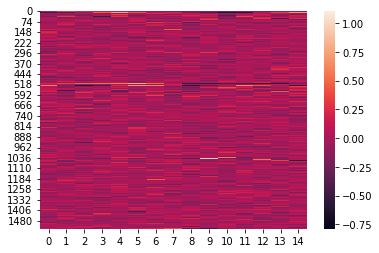

In [ ]:
# y axis is features 
# x axis is classes
sns.heatmap(weights)

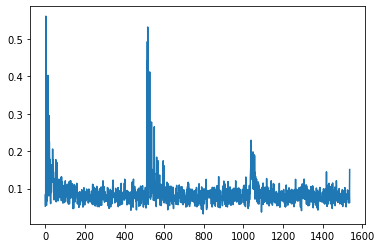

In [ ]:
# x axis is features 
weights_col = np.mean(np.abs(weights), axis=1)
plt.plot(weights_col)

It is the same like discussed above. 

"""
After plotting the weight values with a heatmap and with a line plot. We can easily see that there are three part of the weights (0, 512, 1024) which are activated most (negatively or positively) so we can say that they are the features which affect the result most because they are the coefficients of the input features.

The most effective weights are gathered on 0, 512, 1024 because we extract three different feature vectors and concatenate them to a single feature vector and these three different feature vectors are obtained by applying PCA to flattened images and, as we talked above, PCA gives us the axises that have most variatition on the dataset in order.

The first image is original grayscale image, the second image is image obtained by applying horizontal edge detection filter, the third image is image obtained by applying vertical edge detection filter.

As you can see, the horizontal features are the one which are activated most. This makes sense because we are trying to predict the orientations of the images and the horizontal edges are the best way to detect orientations.

Extra note: the last column for the feature vector are bias.
"""

## 2.a)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

# Train
X_train = train_features
y_train = preprocess_labels(train_orient)

X_test = test_features
y_test = preprocess_labels(test_orient)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


mnb = MultinomialNB()
mnb = mnb.fit(X_train_scaled, y_train)

naive_preds = mnb.predict(X_train_scaled)
acc_train = acc_metric(y_train, naive_preds)

naive_preds = mnb.predict(X_test_scaled)
acc_test = acc_metric(y_test, naive_preds)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

---------------------------
Train Accuracy: 1.0 Test Accuracy: 1.0


Both of the classifiers predicted correctly for the majority of the classes. It might be thanks to extracting useful features and also smoothness of the synthetic dataset 

## 2.b)


Conditional independence does not hold for this case since each pixel is dependent on each other. There is a rotation in each image and the angle defines which pixel stands near which one. Hence, the values of $x_i$ are not conditionally independent.

Besides, the probability of a pixel with a specific value is dependent to pixels that are near to it. Also, we extracted additional features which are the same image with horizontal and vertical filters so it is dependent to the original image, because they are simply the same image with an additional convolutional filter.

## 2.c)

The formula for with and without conditional independence assumption is $2d(k-1)$ and  $2(k^d-1)$. Here, $k=15$ and $d=1536$. 

* With conditional independence: $ 2\cdot 1536 \cdot 14$ parameters to estimate.

* Without conditional independence: $ 2\cdot (15^{1536} - 1) $ parameters to estimate. 

As one can see, there is a significant gap between the amount of parameters to be estimated and without the conditional independence assumption, it is challenging to train a model. 

# References
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- https://www.kaggle.com/code/vitorgamalemos/multinomial-logistic-regression-from-scratch/notebook
- https://www.kaggle.com/code/residentmario/soft-thresholding-with-lasso-regression/notebook
- https://deepnotes.io/softmax-crossentropy